In [1]:
###############################################################
####  CLASIFICACIÓN DE PACIENTES CON NAIVE BAYES (PRÁCTICA) ####
####  Caso aplicado: Riesgo de abandono de tratamiento o      ####
####  hospitalización en aseguradora de salud                ####
###############################################################

# Importar librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import CategoricalNB



In [2]:
# --------------------------------------------------------------
# 1. CREACIÓN DE UN CONJUNTO DE DATOS SIMULADO
# --------------------------------------------------------------
np.random.seed(42)

n = 600  # número de observaciones

data = pd.DataFrame({
    'edad': np.random.randint(18, 80, n),
    'sexo': np.random.choice(['Femenino', 'Masculino'], n),
    'num_consultas': np.random.poisson(3, n),
    'diagnostico': np.random.choice(['Diabetes', 'Hipertensión', 'Depresión', 'Asma'], n),
    'adherencia': np.random.choice(['Alta', 'Media', 'Baja'], n, p=[0.5, 0.3, 0.2]),
    'dias_ultima_cita': np.random.randint(0, 180, n),
    'ingresos': np.random.choice(['Bajos', 'Medios', 'Altos'], n, p=[0.4, 0.4, 0.2]),
    'hist_hospitalizacion': np.random.choice(['Sí', 'No'], n, p=[0.2, 0.8])
})

# Variable objetivo (riesgo de abandono o hospitalización)
data['riesgo'] = np.where(
    (data['adherencia'] == 'Baja') | (data['hist_hospitalizacion'] == 'Sí'), 'Alto', 'Bajo'
)

# Guardar el conjunto de datos simulado
data.to_csv('datos_pacientes.csv', index=False)


In [3]:
# Visualizamos los datos
data.head()

,edad,sexo,num_consultas,diagnostico,adherencia,dias_ultima_cita,ingresos,hist_hospitalizacion,riesgo
0,56,Masculino,2,Depresión,Alta,120,Altos,No,Bajo
1,69,Femenino,0,Depresión,Alta,41,Altos,No,Bajo
2,46,Femenino,2,Depresión,Alta,53,Bajos,No,Bajo
3,32,Femenino,5,Diabetes,Baja,74,Bajos,No,Alto
4,60,Masculino,1,Depresión,Alta,15,Medios,Sí,Alto


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   edad                  600 non-null    int64 
 1   sexo                  600 non-null    object
 2   num_consultas         600 non-null    int64 
 3   diagnostico           600 non-null    object
 4   adherencia            600 non-null    object
 5   dias_ultima_cita      600 non-null    int64 
 6   ingresos              600 non-null    object
 7   hist_hospitalizacion  600 non-null    object
 8   riesgo                600 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.3+ KB


In [5]:
# Tabla de descripción estadística transpuesta y redondeada a 2 deciamles
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
edad,600.0,50.09,18.12,18.0,36.00,50.0,66.00,79.0
num_consultas,600.0,3.07,1.80,0.0,2.00,3.0,4.00,10.0
dias_ultima_cita,600.0,90.48,53.06,0.0,41.75,91.5,138.25,179.0


In [6]:
# Limpiamos los datos duplicados y los missing values
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   edad                  600 non-null    int64 
 1   sexo                  600 non-null    object
 2   num_consultas         600 non-null    int64 
 3   diagnostico           600 non-null    object
 4   adherencia            600 non-null    object
 5   dias_ultima_cita      600 non-null    int64 
 6   ingresos              600 non-null    object
 7   hist_hospitalizacion  600 non-null    object
 8   riesgo                600 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.3+ KB


In [7]:
# Configuración inicial
TARGET = 'riesgo'
FEATURES = ['edad', 'sexo', 'num_consultas', 'diagnostico','dias_ultima_cita', 'ingresos']
df = data[FEATURES + [TARGET]].copy()

# División train/validation
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=1)

# Preparación de datos
X_train = train_df[FEATURES].astype('category').apply(lambda x: x.cat.codes)
y_train = train_df[TARGET].astype('category').cat.codes

# Entrenamiento del modelo
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

# Información de clases y características
classes = train_df[TARGET].astype('category').cat.categories
features = FEATURES

# Resultados compactos
print("\nProbabilidades a priori:")
print(pd.Series(np.exp(nb_model.class_log_prior_), index=classes).round(4))

print("\nProbabilidades condicionales:")
for i, feat in enumerate(features):
    print(f"\n{feat}:")
    cats = train_df[feat].astype('category').cat.categories
    probs = np.exp(nb_model.feature_log_prob_[i])
    
    df_probs = pd.DataFrame(probs, 
                          index=classes, 
                          columns=[f"{feat}={c}" for c in cats])
    print(df_probs.round(4).to_string())


Probabilidades a priori:
Alto    0.3813
Bajo    0.6188
dtype: float64

Probabilidades condicionales:

edad:
      edad=18  edad=19  edad=20  edad=21  edad=22  edad=23  edad=24  edad=25  edad=26  edad=27  edad=28  edad=29  edad=30  edad=31  edad=32  edad=33  edad=34  edad=35  edad=36  edad=37  edad=38  edad=39  edad=40  edad=41  edad=42  edad=43  edad=44  edad=45  edad=46  edad=47  edad=48  edad=49  edad=50  edad=51  edad=52  edad=53  edad=54  edad=55  edad=56  edad=57  edad=58  edad=59  edad=60  edad=61  edad=62  edad=63  edad=64  edad=65  edad=66  edad=67  edad=68  edad=69  edad=70  edad=71  edad=72  edad=73  edad=74  edad=75  edad=76  edad=77  edad=78  edad=79
Alto   0.0122   0.0163   0.0122   0.0163   0.0122   0.0082   0.0163   0.0245   0.0122   0.0041   0.0163   0.0082   0.0163   0.0082   0.0122   0.0163   0.0163   0.0082   0.0041   0.0163   0.0122   0.0122   0.0286   0.0245   0.0163   0.0204   0.0163   0.0041   0.0163   0.0122   0.0041   0.0204   0.0367   0.0082   0.0408   0.0245

In [8]:
# Tabla de contigencia por proporciones entre riesgo y diagostico
contingency_table = pd.crosstab(train_df['diagnostico'], train_df['riesgo'], normalize='index')
print("\nTabla de contingencia (proporciones) entre diagnóstico y riesgo:")
print(contingency_table.round(4).to_string())


Tabla de contingencia (proporciones) entre diagnóstico y riesgo:
riesgo          Alto    Bajo
diagnostico                 
Asma          0.3211  0.6789
Depresión     0.4706  0.5294
Diabetes      0.3643  0.6357
Hipertensión  0.3659  0.6341


In [9]:
# Tabla de contigencia entre riesgo e ingresos
contingency_table_ingresos = pd.crosstab(train_df['ingresos'], train_df['riesgo'], normalize='index')
print("\nTabla de contingencia (proporciones) entre ingresos y riesgo:")
print(contingency_table_ingresos.round(4).to_string())


Tabla de contingencia (proporciones) entre ingresos y riesgo:
riesgo      Alto    Bajo
ingresos                
Altos     0.3372  0.6628
Bajos     0.3788  0.6212
Medios    0.4031  0.5969


In [10]:
# Preprocesar datos de validación (mismo tratamiento que entrenamiento)
X_valid = valid_df.drop('riesgo', axis=1)
X_valid = X_valid.astype('category').apply(lambda col: col.cat.codes)

# Predecir probabilidades y clases
pred_prob = nb_model.predict_proba(X_valid)
pred_class = nb_model.predict(X_valid)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'actual': valid_df['riesgo'].values,
    'predicted': pred_class,
    f'prob_{nb_model.classes_[0]}': pred_prob[:, 0],
    f'prob_{nb_model.classes_[1]}': pred_prob[:, 1]
})

print("\nResultados de validación:")
print(results_df.head())


Resultados de validación:
  actual  predicted    prob_0    prob_1
0   Alto          0  0.512176  0.487824
1   Bajo          1  0.198312  0.801688
2   Bajo          1  0.126773  0.873227
3   Bajo          1  0.179407  0.820593
4   Alto          0  0.520599  0.479401


In [11]:
# Preprocesar datos de validación (mismo tratamiento que entrenamiento)
X_valid = valid_df.drop('riesgo', axis=1)
X_valid = X_valid.astype('category').apply(lambda col: col.cat.codes)

# Predecir probabilidades y clases
pred_prob = nb_model.predict_proba(X_valid)
pred_class = nb_model.predict(X_valid)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'actual': valid_df['riesgo'],
    'predicted': pd.Categorical.from_codes(pred_class, categories=nb_model.classes_),
    'prob alto': pred_prob[:, 0],  # Probabilidad clase 0
    'prob bajo': pred_prob[:, 1]   # Probabilidad clase 1
})

print("\nResultados de validación:")
print(results_df.head())


Resultados de validación:
    actual predicted  prob alto  prob bajo
446   Alto         0   0.512176   0.487824
404   Bajo         1   0.198312   0.801688
509   Bajo         1   0.126773   0.873227
455   Bajo         1   0.179407   0.820593
201   Alto         0   0.520599   0.479401


In [12]:
# Predección de un nuevo paciente
new_patient = pd.DataFrame({
    'edad': [45],
    'sexo': ['Femenino'],
    'num_consultas': [5],
    'diagnostico': ['Diabetes'],
    'dias_ultima_cita': [30],
    'ingresos': ['Medios']
})
new_patient_encoded = new_patient.astype('category').apply(lambda col: col.cat.codes)
pred_new = nb_model.predict(new_patient_encoded)
pred_prob_new = nb_model.predict_proba(new_patient_encoded)
print("\nPredicción para nuevo paciente:")
print(f"Clase predicha: {nb_model.classes_[pred_new][0]}")
print(f"Probabilidades: {pred_prob_new[0]}")


Predicción para nuevo paciente:
Clase predicha: 1
Probabilidades: [0.27830488 0.72169512]


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convertir las clases a strings (si son numéricas)
class_names = [str(cls) for cls in nb_model.classes_]

# Para entrenamiento
pred_class_train = nb_model.predict(X_train)
print("Matriz de confusión - Entrenamiento:")
print(confusion_matrix(y_train, pred_class_train))
print("\nReporte - Entrenamiento:")
print(classification_report(y_train, pred_class_train, target_names=class_names))

# Codificar X_valid
X_valid_encoded = X_valid.astype('category').apply(lambda col: col.cat.codes)

# Codificar y_valid
y_valid = valid_df[TARGET].astype('category').cat.codes

# Para validación
pred_class_valid = nb_model.predict(X_valid_encoded)
print("\nMatriz de confusión - Validación:")
print(confusion_matrix(y_valid, pred_class_valid))
print("\nReporte - Validación:")
print(classification_report(y_valid, pred_class_valid, target_names=class_names))

Matriz de confusión - Entrenamiento:
[[119  64]
 [ 31 266]]

Reporte - Entrenamiento:
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       183
           1       0.81      0.90      0.85       297

    accuracy                           0.80       480
   macro avg       0.80      0.77      0.78       480
weighted avg       0.80      0.80      0.80       480


Matriz de confusión - Validación:
[[16 25]
 [25 54]]

Reporte - Validación:
              precision    recall  f1-score   support

           0       0.39      0.39      0.39        41
           1       0.68      0.68      0.68        79

    accuracy                           0.58       120
   macro avg       0.54      0.54      0.54       120
weighted avg       0.58      0.58      0.58       120



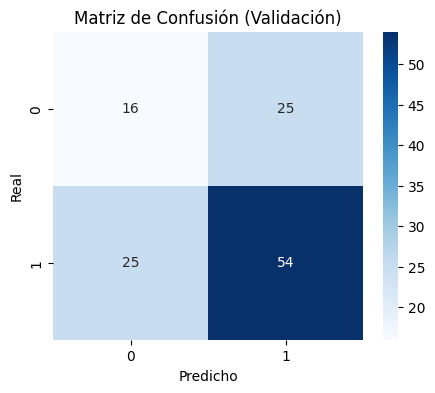

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=nb_model.classes_, 
                yticklabels=nb_model.classes_)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

# Para validación
plot_confusion_matrix(y_valid, pred_class_valid, 'Matriz de Confusión (Validación)')

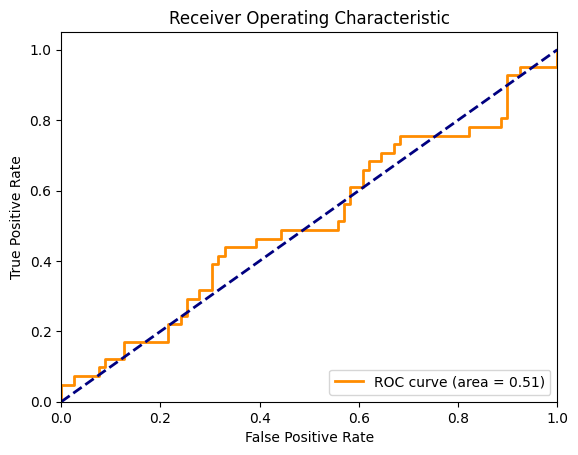

In [15]:
# Grafico de ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid, pred_prob[:, 0], pos_label=nb_model.classes_.tolist().index(0))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()